## Imports and functions

In [7]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
import anndata as ad
import h5py
import scanpy as sc
import re
import os
import os.path as osp
import sys
from matplotlib_venn import venn2, venn3
from random import sample
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import add_remaining_self_loops, to_undirected
from tqdm import tqdm
import torch.optim as optim
from pdgrapher import Dataset, PDGrapher, Trainer

# borrowed from stackoverflow (https://stackoverflow.com/questions/61133916/is-there-in-python-a-single-function-that-shows-the-full-structure-of-a-hdf5-fi)
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')

def output_divider():
    print('----------------------------------------')

## 4/4

Starting today our objective shifts to using LINCS level 3 overexpression data. LINCS is a bulk, microarray seqenced dataset. Julia's data is single cell and could be a problem due to mainly inherent distribution difference from the training dataset. 

Today we aim to download and QC the oe dataset using the same script for xpr

In [ ]:
# wget https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/level3/level3_beta_trt_oe_n131668x12328.gctx -O /home/b-evelyntong/hl/lincs_lvl3_oe

In [14]:
### pushing through every line of code that processes the data from its original format into npz format
DATA_ROOT="/home/b-evelyntong/hl/lincs_lvl3_oe"

### STEP 1 LOAD
# this chunk loads in instinfo_beta and geneinfo_beta, specific to LINCS, the former for cells and latter for information on genes
# instinfo contains information on which perturbation each cell went through
inst_info = pd.read_csv(os.path.join(DATA_ROOT, 'instinfo_beta.txt'), sep="\t", low_memory=False)
gene_info = pd.read_csv(os.path.join(DATA_ROOT, 'geneinfo_beta.txt'), sep="\t", low_memory=False)

# these steps make sure that inst_info_xxx contains the subset of cells that are either is in the 
# treatment group and perturbed with crispr, or is in the control group and received only a vector
inst_info_ctl = inst_info[np.logical_and(inst_info['pert_type'] == 'ctl_vector', inst_info['failure_mode'].isna()) ].reset_index(inplace=False, drop=True)
inst_info_oe = inst_info[np.logical_and(inst_info['pert_type'] == 'trt_oe', inst_info['failure_mode'].isna()) ].reset_index(inplace=False, drop=True)

# reads in h5py file and creates a panda dataframe out of it
f = h5py.File(os.path.join(DATA_ROOT, 'level3_beta_trt_oe_n131668x12328.gctx'), 'r')
matrix_oe = f['0']['DATA']['0']['matrix'][:].transpose()
gene_ids_oe = f['0']['META']['ROW']['id'][:]
sample_ids_oe = f['0']['META']['COL']['id'][:]
matrix_oe = pd.DataFrame(matrix_oe, columns = sample_ids_oe.astype(str), index = gene_ids_oe.astype(int))
del f

### Control data
f = h5py.File(os.path.join(DATA_ROOT, 'level3_beta_ctl_n188708x12328.gctx'), 'r')
matrix_ctl = f['0']['DATA']['0']['matrix'][:].transpose()
gene_ids_ctl = f['0']['META']['ROW']['id'][:]					#not in the same order as gene_ids_xpr
sample_ids_ctl = f['0']['META']['COL']['id'][:]
matrix_ctl = pd.DataFrame(matrix_ctl, columns = sample_ids_ctl.astype(str), index = gene_ids_ctl.astype(int))
del f

#re-order gene_info based on the order in gene_ids_xpr (rows of data)
gene_info.index = gene_info['gene_id']
gene_info = gene_info.loc[gene_ids_oe.astype(int)].reset_index(inplace=False, drop=True)

# output here is inst_info_xpr, inst_info_ctl, gene_info, matrix_xpr, matrix_ctl


### STEP 2 FILTER METADATA
#CRISPR
list_ids = list(inst_info_oe['sample_id'])	#in metadata
matrix_oe = matrix_oe[list_ids]	#Filtered data matrix
#CONTROL
list_ids = list(inst_info_ctl['sample_id'])	#in metadata
list_ids = list(set(list_ids).intersection(set(matrix_ctl.columns.astype(str))))	#in metadata and in data matrix (some of metadata are not in data matrix)
inst_info_ctl.index = inst_info_ctl['sample_id']; inst_info_ctl = inst_info_ctl.loc[list_ids].reset_index(inplace=False, drop=True) #remove entries from metadata that are not in data matrix
matrix_ctl = matrix_ctl[list_ids]	#Filtered data matrix
# output here is inst_info_xpr, matrix_xpr, inst_info_ctl, matrix_ctl
# by the end of this, inst_info_xpr is now # perturbed cells as N rows, matrix_xpr is # genes expressed X # perturbed cells. visa versa for ctl

In [ ]:
# print(inst_info_oe[['cell_iname', 'cmap_name']])
# a list of unique cell lines found in oe
# unique_cell_lines = set(inst_info_oe['cell_iname'])
print(inst_info_oe[['cell_iname', 'cmap_name']].groupby(['cell_iname']).size().sort_values(ascending=False))

# top cell lines that have > 4000 genes overexpressed:
# A549, PC3, A375, HEK293T, HA1E, MCF7, HT29, VCAP

# overlap of kept cell lines between xpr and oe is 
# A549, PC3, A375, MCF7, HT29

cell_iname
A549       17196
PC3        12374
A375       12001
HEK293T    10647
HA1E       10173
MCF7        8453
HT29        8104
VCAP        5099
HCC515      3814
AALE        3164
H1299       2858
SALE        2445
HEPG2       1291
U2OS         561
HUH7         314
RWPE1        190
LHSAR        180
LNCAP        135
HEK293        20
HELA          16
dtype: int64


In [42]:
# STEP 3 FILTER BY CELLLINE

#####OE
#Obtain cell lines with the most perturbations (> 4K genes perturbed)
keep_cell_lines = ['A549', 'PC3', 'A375', 'HEK293T', 'HA1E', 'MCF7', 'HT29', 'VCAP']
#Find indices of samples that are on the desired cell lines
keep_index = []
for i in range(len(inst_info_oe)):
    if inst_info_oe.at[i, 'cell_iname'] in keep_cell_lines:
        keep_index.append(i)
inst_info_oe = inst_info_oe.loc[keep_index].reset_index(inplace=False, drop=True) #filter from metadata
list_ids = list(inst_info_oe['sample_id'])	#obtain sample ID from metadata
matrix_oe = matrix_oe[list_ids]	#Filtered data matrix
#####CONTROL
keep_index = []
for i in range(len(inst_info_ctl)):
    if inst_info_ctl.at[i, 'cell_iname'] in keep_cell_lines:
        keep_index.append(i)
inst_info_ctl = inst_info_ctl.loc[keep_index].reset_index(inplace=False, drop=True)  #filter from metadata
list_ids = list(inst_info_ctl['sample_id'])	#obtain sample ID from metadata
matrix_ctl = matrix_ctl[list_ids]	#Filtered data matrix


In [50]:
print(matrix_ctl.shape)
print(matrix_oe.shape)

print(inst_info_ctl.shape)
print(inst_info_oe.shape)

(12328, 32018)
(12328, 84047)
(32018, 30)
(84047, 30)


In [51]:
# STEO 4 FILTER UNKNOWN PERTURBED GENES (indeed unique to xpr, or the treatment group)
# this matches the perturbed gene of each of the cells kept from previous steps to the gene names recorded in gene_info, if it's not there then drop
known_genes = list(set(gene_info['gene_symbol']))
keep_index = []
for i in range(len(inst_info_oe)):
    if inst_info_oe.at[i, 'cmap_name'] in known_genes:
        keep_index.append(i)

inst_info_oe = inst_info_oe.loc[keep_index].reset_index(inplace=False, drop=True) #filter from metadata
list_ids = list(inst_info_oe['sample_id'])	#obtain sample ID from metadata
matrix_oe = matrix_oe[list_ids]
# only inst_info_xpr, matrix_xpr are returned here

In [52]:
print(matrix_ctl.shape)
print(matrix_oe.shape)

print(inst_info_ctl.shape)
print(inst_info_oe.shape)

(12328, 32018)
(12328, 65010)
(32018, 30)
(65010, 30)


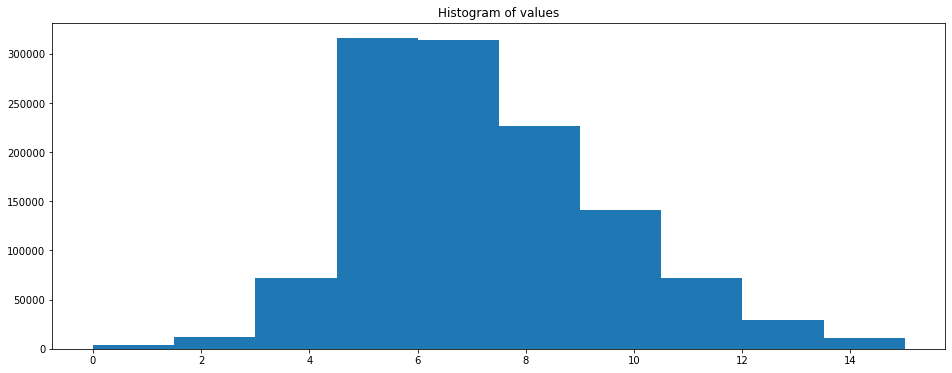

In [53]:
# STEP 5 NORMALIZE AND SAVE TO NPZ
# note all previous variables were passed here and this function simply returned as it normalizes and saves to a directory. 

# note here they concatenated the ctl and the xpr indices because indeed they wouldn't overlap as the two lists were taken from the inst info in the first place
metadata = pd.concat([inst_info_oe, inst_info_ctl], axis=0).reset_index(inplace=False, drop=True)
# here they create the file that records each cell id and their metadata attributes
# metadata.to_csv(osp.join(outdir, 'all_metadata.txt'))
# !!!!!! here they concatenated the gene matrices, by extending the cells dimension (gene dimension stays the same)
matrix = pd.concat([matrix_oe, matrix_ctl], axis=1)
del(matrix_oe)

# note the below histogram shows that most values (of the .1% of all samples in the concatenated matrix) have a value of ~6
mv = matrix.values.flatten() # collapses value into one line for sampling
sampling = sample(range(len(mv)), int(0.001*len(mv)))  # pick 1/1000 of the total samples in the big matrix
mv = mv[sampling]

fig, ax = plt.subplots(figsize=(16,6))
ax.hist(mv)
ax.set_title('Histogram of values')
plt.show()

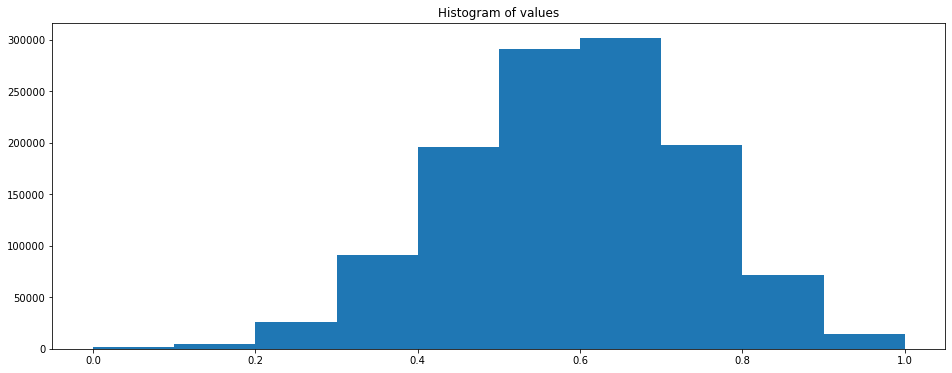

In [54]:
#NORMALIZATION
# log + min max normalize, after this the values of matrix will be between 0 and 1
matrix = np.log2(matrix + 1)
scaler = MinMaxScaler((0,1))
matrix = matrix.transpose()
matrix = pd.DataFrame(scaler.fit_transform(matrix), columns = matrix.columns, index = matrix.index)
matrix = matrix.transpose()

#hist of values after lognorm
mv = matrix.values.flatten()
sampling = sample(range(len(mv)), int(0.001*len(mv)))
mv = mv[sampling]

# this gives that most values are at 0.6, and this is a very nice normal distribution 
fig, ax = plt.subplots(figsize=(16,6))
ax.hist(mv)
ax.set_title('Histogram of values')
plt.show()

In [56]:
#2. Save data and metadata for each condition and cell line
#Compound + cell lines
#Control + cell lines
outdir = "/home/b-evelyntong/hl/lincs_lvl3_oe/processed"
metadata.index = metadata['sample_id']
metadata = metadata.loc[matrix.columns]	#sort metadata given by column order in data matrix (and filter samples that have been filtered out from matrix during binarization)
for cell_line in keep_cell_lines:
    for pert_type in ['trt_oe', 'ctl_vector']:
        metadata_i = metadata[np.logical_and(metadata['cell_iname'] == cell_line, metadata['pert_type'] == pert_type)]
        data_i = matrix[metadata_i.index]
        metadata_i.to_csv(osp.join(outdir, 'cell_line_{}_pert_{}_metadata.txt'.format(cell_line, pert_type)), index=False)
        filename = 'cell_line_{}_pert_{}'.format(cell_line, pert_type)
        np.savez_compressed(osp.join(outdir, filename), data=data_i.values, row_ids = data_i.index, col_ids=data_i.columns)

In [ ]:
# looking for if any healthy counterpart existed for the cell lines we selected for oe
#  ['A549', 'PC3', 'A375', 'HEK293T', 'HA1E', 'MCF7', 'HT29', 'VCAP']
cell_line_info = pd.read_csv('/home/b-evelyntong/hl/PDGrapher/data/raw/lincs/2022-02-LINCS_Level3/data/cellinfo_beta.txt', sep='\t')
cell_line_info[cell_line_info['cell_iname'].isin( ['A549', 'PC3', 'A375', 'HEK293T', 'HA1E', 'MCF7', 'HT29', 'VCAP'])]

# here I realize that HEK293T and HA1E are normal tissues, and decide to keep them -- could be interesting to see

# A375 and HT29 do not have healthy counterparts
# A549 has known healthy counterpart NL20
# PC3 and VCAP has known healthy RWPE1 ... even though it says it's also tumor but gonzalez used it so
# MCF7 has known healthy MCF10A

# so for the pt export loop, we have:
# for cell_line, healthy in zip(['A549', 'MCF7', 'PC3', 'VCAP'], [('NL20', 'ctl_vehicle'), ('MCF10A', 'ctl_untrt'), ('RWPE1', 'ctl_vector'), ('RWPE1', 'ctl_vector')]):
# for cell_line, healthy in zip(['A375', 'HT29', 'HEK293T', 'HA1E'], [None, None, None, None]):

,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
8,HEK293T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,293T
97,HA1E,NaN,NaN,NaN,NaN,60,MEM-ALPHA (Invitrogen A1049001) supplemented w...,NaN,NaN,normal,Unknown,Unknown,Unknown,kidney,normal kidney sample,normal kidney sample,NaN,unknown,HA1E_KIDNEY,NaN
113,A549,CVCL_0023,58,NaN,NaN,48,F-12K ATCC catalog # 3-24,CCL-185,c-4,tumor,Caucasian,M,Primary,lung,lung cancer,non small cell carcinoma,ATCC,adherent,A549_LUNG,A 549
129,A375,CVCL_0132,54,NaN,NaN,36,DMEM Invitrogen catalog # 11995-65,CRL-1619,c-127,tumor,Unknown,F,Metastatic,skin,skin cancer,melanoma,ATCC,adherent,A375_SKIN,A 375|A-375
138,HT29,CVCL_0320,44,NaN,NaN,36,McCoy's 5A Invitrogen catalog # 166-82,HTB-38,c-272,tumor,Caucasian,F,Primary,large_intestine,colon cancer,adenocarcinoma,ATCC,adherent,HT29_LARGE_INTESTINE,HT 29
151,MCF7,CVCL_0031,40,NaN,NaN,72,EMEM ATCC catalog # 3-23,HTB-22,c-438,tumor,Caucasian,F,Metastatic,breast,breast cancer,adenocarcinoma,ATCC,adherent,MCF7_BREAST,IBMF-7
165,PC3,CVCL_0035,62,NaN,NaN,72,F-12K ATCC catalog # 3-24,CRL-1435,c-214,tumor,Caucasian,M,Metastatic,prostate,prostate cancer,adenocarcinoma,ATCC,mix,PC3_PROSTATE,PC.3|PC-3
167,VCAP,CVCL_2235,NaN,NaN,NaN,220,DMEM ATCC catalog # 3-22,NaN,NaN,tumor,Caucasian,M,Metastatic,prostate,prostate cancer,adenocarcinoma,ATCC,adherent,VCAP_PROSTATE,Vcap


In [5]:
# 4/6
# since we don't have cosmic data file yet, I'll treat these cell lines as having no healthy counterparts for now so I can continue to test

data_root_dir = "/home/b-evelyntong/hl/lincs_lvl3_oe/processed"
# for cell_line, healthy in zip(['A549', 'MCF7', 'PC3', 'VCAP'], [('NL20', 'ctl_vehicle'), ('MCF10A', 'ctl_untrt'), ('RWPE1', 'ctl_vector'), ('RWPE1', 'ctl_vector')]):
for cell_line, healthy in zip(['A549', 'MCF7', 'PC3', 'VCAP'], [None, None, None, None]):
# load_ppi
	ppi = nx.read_edgelist("/home/b-evelyntong/hl/PDGrapher/data/processed/ppi/ppi_all_genes_edgelist.txt")

# load_gene_metadata (supposedly only gene_info is used)
	gene_info = pd.read_csv("/home/b-evelyntong/hl/PDGrapher/data/processed/lincs/gene_info.txt")
	dict_entrez_symbol = dict(zip(gene_info['gene_id'], gene_info['gene_symbol']))
	dict_symbol_entrez = dict(zip(gene_info['gene_symbol'], gene_info['gene_id']))

################################ uncomment when I get cosmic ######################################
# # load_healthy_data
# 	healthy_data_path = osp.join(data_root_dir, 'cell_line_{}_pert_{}.npz'.format(healthy[0], healthy[1]))
# 	healthy_metadata_path = osp.join(data_root_dir, 'cell_line_{}_pert_{}_metadata.txt'.format(healthy[0], healthy[1]))
# 	#Loads metadata
# 	healthy_metadata = pd.read_csv(healthy_metadata_path)
# 	#Loads data
# 	with np.load(healthy_data_path, allow_pickle=True) as arr:
# 		healthy_data =arr['data']
# 		col_ids = arr['col_ids']
# 		row_ids = arr['row_ids']
# 	healthy_data = pd.DataFrame(healthy_data, columns= col_ids, index=row_ids)
# 	print('Loading healthy cell line:\t{} Number of samples:\t{}\n'.format(healthy[0], healthy_data.shape[1]))

# # load_cosmic
# 	data = pd.read_csv('CosmicCLP_MutantExport_only_verified_and_curated')
# 	print('Loading COSMIC data. Number of cell lines:\t{}\n'.format(len(set(data['Sample name']))))
# # map_cosmic_to_lincs
# 	cosmic_data = cosmic_data[cosmic_data['Sample name']==cell_line]
# 	print('Mapping cosmic genes to lincs. Mapped: {}/{}\n'.format(len(set(cosmic_data['Gene name']).intersection(gene_info['gene_symbol'])), len(set(cosmic_data['Gene name']))))
# 	#Filter genes not mapped to LINCS
# 	cosmic_data = cosmic_data[[gene_symbol in dict_symbol_entrez for gene_symbol in cosmic_data['Gene name']]]
# 	#Save COSMIC mutations as entrez id (dataframe index)
# 	try:
# 		cosmic_mutations = list(set([dict_symbol_entrez[symbol] for symbol in cosmic_data['Gene name'].tolist()]))
# 	except:
# 		import pdb; pdb.set_trace()
	healthy_data = None
	cosmic_mutations = None
#############################################################################################
	
# load_data
	#Loads data matrix (observational)
	file = osp.join(data_root_dir, 'cell_line_{}_pert_ctl_vector.npz'.format(cell_line))
	file_metadata = osp.join(data_root_dir, 'cell_line_{}_pert_ctl_vector_metadata.txt'.format(cell_line))
	obs_metadata = pd.read_csv(file_metadata)
	with np.load(file, allow_pickle=True) as arr:
		obs_data =arr['data']
		col_ids = arr['col_ids']
		row_ids = arr['row_ids']
	obs_data = pd.DataFrame(obs_data, columns= col_ids, index=row_ids)
	print('Number of observational datapoints:\t{}\n'.format(len(obs_metadata)))
	#Loads data matrix (interventional)
	file = osp.join(data_root_dir, 'cell_line_{}_pert_trt_oe.npz'.format(cell_line))
	file_metadata = osp.join(data_root_dir, 'cell_line_{}_pert_trt_oe_metadata.txt'.format(cell_line))
	int_metadata = pd.read_csv(file_metadata)
	with np.load(file, allow_pickle=True) as arr:
		int_data =arr['data']
		col_ids = arr['col_ids']
		row_ids = arr['row_ids']
	int_data = pd.DataFrame(int_data, columns= col_ids, index=row_ids)
	print('Number of interventional datapoints:\t{}\n'.format(len(int_metadata)))
# filter_data
	cosmic_mutations = None
	#1.Filter out obs and int data to keep only genes that are in the PPI
	gene_symbols_in_ppi = list(ppi.nodes())
	#####
	# this code was buggy for keying non-existent gene in ppi
	# BECAUSE I SHORT CUTTED THE LOOP and gene_info was modified in place LOL
	dict_symbol_id = dict(zip(gene_info['gene_symbol'], gene_info['gene_id']))
	gene_ids_in_ppi = [dict_symbol_id[i] for i in gene_symbols_in_ppi]
	gene_info.index = gene_info['gene_id']; gene_info = gene_info.loc[gene_ids_in_ppi].reset_index(inplace=False, drop=True)
	obs_data = obs_data.loc[gene_ids_in_ppi]
	int_data = int_data.loc[gene_ids_in_ppi]
	######
	if healthy_data is not None:
		healthy_data = healthy_data.loc[gene_ids_in_ppi]
	if cosmic_mutations is not None:
		cosmic_mutations = pd.DataFrame(cosmic_mutations)[[e in gene_ids_in_ppi for e in cosmic_mutations]][0].tolist()
	#2. Filter out samples whose interventions are not in the remaining genes (those in the PPI)
	keep = []
	for i, gene_symbol in enumerate(int_metadata['cmap_name']):
		if gene_symbol in gene_symbols_in_ppi:
			keep.append(int_metadata.at[i, 'sample_id'])
	int_metadata.index = int_metadata['sample_id']; int_metadata = int_metadata.loc[keep].reset_index(inplace=False, drop=True)
	int_data = int_data[keep]
	print('Number of interventional datapoints after keeping only those with perturbed genes in PPI:\t{}\n'.format(len(int_metadata)))
	print('Assembling data...\n')

	#First, we re-index genes in PPI and data
		#Gene symbol to index to ordered index
	gene_symbol_to_index = dict(zip(gene_info['gene_symbol'], gene_info['gene_id']))
	gene_index_to_ordered_index = dict(zip(gene_info['gene_id'], range(len(gene_info))))
	gene_info['ordered_index'] = [gene_index_to_ordered_index[i] for i in gene_info['gene_id']]


		#Reindex genes in PPI, obs_data, int_data, healty_data, and cosmic_mutations
	ppi = nx.relabel_nodes(ppi, gene_symbol_to_index)
	ppi = nx.relabel_nodes(ppi, gene_index_to_ordered_index)
	int_data.index = [gene_index_to_ordered_index[i] for i in int_data.index]
	int_data = int_data.sort_index(inplace=False)
	obs_data.index = [gene_index_to_ordered_index[i] for i in obs_data.index]
	obs_data = obs_data.sort_index(inplace=False)
	if healthy_data is not None:
		healthy_data.index = [gene_index_to_ordered_index[i] for i in healthy_data.index]
		healthy_data = healthy_data.sort_index(inplace=False)
	if cosmic_mutations is not None:
		cosmic_mutations = [gene_index_to_ordered_index[i] for i in cosmic_mutations]
		cosmic_vector = np.zeros(len(healthy_data))
		cosmic_vector[cosmic_mutations] = 1

	#Assembling samples
	edge_index = torch.LongTensor(np.array(ppi.edges()).transpose())
	edge_index = add_remaining_self_loops(edge_index)[0]
	edge_index = to_undirected(edge_index)
	number_of_nodes = ppi.number_of_nodes()

	#remove incoming edges to perturbed nodes (mutated nodes)
	# mask = [e not in cosmic_mutations for e in edge_index[1,:]]
	# edge_index_mutilated = edge_index[:, mask]
	# edge_index_mutilated = add_remaining_self_loops(edge_index_mutilated)[0]

	dict_forward_sample_and_mutations = dict() #saves the mutation vector used in forward

	forward_data_list = []
	if healthy_data is not None: #we only build forward data when we have healthy samples
		#FORWARD DATA - healthy_data, cosmic_vector, obs_data
			#each Data object will be a pairing of a random healthy_data column, the cosmic mutations, and a obs_data column
			#will have as many as obs_data columns
		i = 0
		order = np.array(range(healthy_data.shape[1]))
		np.random.shuffle(order)
		for sample_id in obs_data.columns:
			#sample a random healthy GE vector
			i = i % healthy_data.shape[1]
			sample_index = order[i]
			healthy_sample = healthy_data[healthy_data.columns[i]].values
			healthy = torch.Tensor(healthy_sample)
			#mutation
			#randomize mutations. First select the percentage of mutations to include, then select the mutations
			perc_to_include = np.random.choice([0.25, 0.50, 0.75, 1], 1).item()
			if int_metadata['cell_mfc_name'][0].split('.')[0] == 'PC3':
				perc_to_include = 1
			cosmic_mutations_i = np.random.choice(cosmic_mutations, int(len(cosmic_mutations)* perc_to_include))
			cosmic_vector = np.zeros(len(healthy_data))
			cosmic_vector[cosmic_mutations_i] = 1
			mutations = torch.Tensor(cosmic_vector)
			#diseased
			diseased = torch.Tensor(obs_data[sample_id])
			data = Data(healthy = healthy, mutations=mutations, diseased=diseased, gene_symbols = gene_info['gene_symbol'].tolist())
			data.num_nodes = number_of_nodes
			forward_data_list.append(data)
			#Save 
			i +=1
			dict_forward_sample_and_mutations[sample_id] = mutations
		print('finished data forward')


	#BACKWARD DATA - obs_data, int_data
	#dict sample id: perturbed gene ordered index
	dict_sample_id_perturbed_gene_ordered_index = dict()
	for sample_id, cmap_name in zip(int_metadata['sample_id'], int_metadata['cmap_name']):
		dict_sample_id_perturbed_gene_ordered_index[sample_id] = gene_index_to_ordered_index[gene_symbol_to_index[cmap_name]]


	#these are helpers to sample from obs_data
	order = np.array(range(obs_data.shape[1]))
	np.random.shuffle(order)
	i = 0
	#shuffle obs data columns
	backward_data_list = []
	unique_names_pert = set()
	for sample_id in int_data.columns:
		binary_indicator_perturbation = np.zeros(len(int_data))
		binary_indicator_perturbation[dict_sample_id_perturbed_gene_ordered_index[sample_id]] = 1
		#Get a random pre-intervention sample
		i = i % obs_data.shape[1]
		sample_index = order[i]
		obs_sample_id = obs_data.columns[i]
		obs_sample = obs_data[obs_data.columns[i]].values
		#concat initial node features and perturbation indicator
		diseased = torch.Tensor(obs_sample)
		intervention = torch.Tensor(binary_indicator_perturbation)
		if healthy_data is not None:
			mutations = dict_forward_sample_and_mutations[obs_sample_id]
		else:
			mutations = torch.Tensor(np.zeros(len(diseased)))
		# torch.Tensor(np.stack([obs_sample, binary_indicator_perturbation], 1))
		#post-intervention
		treated = torch.Tensor(int_data[sample_id])
		#remove incoming edges to perturbed node
		# perturbed_node = dict_sample_id_perturbed_gene_ordered_index[sample_id]
		# edge_index_mutilated = edge_index[:, edge_index[1,:] != perturbed_node]
		
		gene_name = int_metadata[int_metadata['sample_id'] == sample_id]['cmap_name'].item()
		unique_names_pert.add(gene_name)
		data = Data(perturbagen_name = gene_name, diseased = diseased, intervention=intervention, treated = treated, gene_symbols = gene_info['gene_symbol'].tolist(), mutations = mutations)
		data.num_nodes = number_of_nodes
		backward_data_list.append(data)
		i +=1

	print('Samples forward:\t{}\n'.format(len(forward_data_list)))
	print('Samples backward:\t{}\n'.format(len(backward_data_list)))
	print('Unique perturbagens:\t{}\n'.format(len(unique_names_pert)))

# save_data
	print('Saving data {} ...\n\n\n'.format(cell_line))
	
	outdir = '/home/b-evelyntong/hl/lincs_lvl3_oe/pt'
	torch.save(forward_data_list, osp.join(outdir, 'data_forward_{}.pt'.format(cell_line)))
	torch.save(backward_data_list, osp.join(outdir, 'data_backward_{}.pt'.format(cell_line)))
	torch.save(edge_index, osp.join(outdir, 'edge_index_{}.pt'.format(cell_line)))

Number of observational datapoints:	4327

Number of interventional datapoints:	14047

Number of interventional datapoints after keeping only those with perturbed genes in PPI:	12642

Assembling data...

Samples forward:	0

Samples backward:	12642

Unique perturbagens:	1390

Saving data A549 ...



Number of observational datapoints:	4852

Number of interventional datapoints:	5464

Number of interventional datapoints after keeping only those with perturbed genes in PPI:	4495

Assembling data...

Samples forward:	0

Samples backward:	4495

Unique perturbagens:	1473

Saving data MCF7 ...



Number of observational datapoints:	6890

Number of interventional datapoints:	10192

Number of interventional datapoints after keeping only those with perturbed genes in PPI:	8751

Assembling data...

Samples forward:	0

Samples backward:	8751

Unique perturbagens:	1692

Saving data PC3 ...



Number of observational datapoints:	4184

Number of interventional datapoints:	4239

Number of interventional

In [ ]:
data_root_dir = "/home/b-evelyntong/hl/lincs_lvl3_oe/processed"
for cell_line, healthy in zip(['A375', 'HT29', 'HEK293T', 'HA1E'], [None, None, None, None]):
# load_ppi
	ppi = nx.read_edgelist("/home/b-evelyntong/hl/PDGrapher/data/processed/ppi/ppi_all_genes_edgelist.txt")

# load_gene_metadata (supposedly only gene_info is used)
	gene_info = pd.read_csv("/home/b-evelyntong/hl/PDGrapher/data/processed/lincs/gene_info.txt")
	
# load_data
	#Loads data matrix (observational)
	file = osp.join(data_root_dir, 'cell_line_{}_pert_ctl_vector.npz'.format(cell_line))
	file_metadata = osp.join(data_root_dir, 'cell_line_{}_pert_ctl_vector_metadata.txt'.format(cell_line))
	obs_metadata = pd.read_csv(file_metadata)
	with np.load(file, allow_pickle=True) as arr:
		obs_data =arr['data']
		col_ids = arr['col_ids']
		row_ids = arr['row_ids']
	obs_data = pd.DataFrame(obs_data, columns= col_ids, index=row_ids)
	print('Number of observational datapoints:\t{}\n'.format(len(obs_metadata)))
	#Loads data matrix (interventional)
	file = osp.join(data_root_dir, 'cell_line_{}_pert_trt_oe.npz'.format(cell_line))
	file_metadata = osp.join(data_root_dir, 'cell_line_{}_pert_trt_oe_metadata.txt'.format(cell_line))
	int_metadata = pd.read_csv(file_metadata)
	with np.load(file, allow_pickle=True) as arr:
		int_data =arr['data']
		col_ids = arr['col_ids']
		row_ids = arr['row_ids']
	int_data = pd.DataFrame(int_data, columns= col_ids, index=row_ids)
	print('Number of interventional datapoints:\t{}\n'.format(len(int_metadata)))
# filter_data
	healthy_data = None
	healthy_metadata = None
	cosmic_mutations = None
	#1.Filter out obs and int data to keep only genes that are in the PPI
	gene_symbols_in_ppi = list(ppi.nodes())
	#####
	# this code was buggy for keying non-existent gene in ppi
	# BECAUSE I SHORT CUTTED THE LOOP and gene_info was modified in place LOL
	dict_symbol_id = dict(zip(gene_info['gene_symbol'], gene_info['gene_id']))
	gene_ids_in_ppi = [dict_symbol_id[i] for i in gene_symbols_in_ppi]
	gene_info.index = gene_info['gene_id']; gene_info = gene_info.loc[gene_ids_in_ppi].reset_index(inplace=False, drop=True)
	obs_data = obs_data.loc[gene_ids_in_ppi]
	int_data = int_data.loc[gene_ids_in_ppi]
	######
	if healthy_data is not None:
		healthy_data = healthy_data.loc[gene_ids_in_ppi]
	if cosmic_mutations is not None:
		cosmic_mutations = pd.DataFrame(cosmic_mutations)[[e in gene_ids_in_ppi for e in cosmic_mutations]][0].tolist()
	#2. Filter out samples whose interventions are not in the remaining genes (those in the PPI)
	keep = []
	for i, gene_symbol in enumerate(int_metadata['cmap_name']):
		if gene_symbol in gene_symbols_in_ppi:
			keep.append(int_metadata.at[i, 'sample_id'])
	int_metadata.index = int_metadata['sample_id']; int_metadata = int_metadata.loc[keep].reset_index(inplace=False, drop=True)
	int_data = int_data[keep]
	print('Number of interventional datapoints after keeping only those with perturbed genes in PPI:\t{}\n'.format(len(int_metadata)))
	print('Assembling data...\n')

	#First, we re-index genes in PPI and data
		#Gene symbol to index to ordered index
	gene_symbol_to_index = dict(zip(gene_info['gene_symbol'], gene_info['gene_id']))
	gene_index_to_ordered_index = dict(zip(gene_info['gene_id'], range(len(gene_info))))
	gene_info['ordered_index'] = [gene_index_to_ordered_index[i] for i in gene_info['gene_id']]


		#Reindex genes in PPI, obs_data, int_data, healty_data, and cosmic_mutations
	ppi = nx.relabel_nodes(ppi, gene_symbol_to_index)
	ppi = nx.relabel_nodes(ppi, gene_index_to_ordered_index)
	int_data.index = [gene_index_to_ordered_index[i] for i in int_data.index]
	int_data = int_data.sort_index(inplace=False)
	obs_data.index = [gene_index_to_ordered_index[i] for i in obs_data.index]
	obs_data = obs_data.sort_index(inplace=False)
	if healthy_data is not None:
		healthy_data.index = [gene_index_to_ordered_index[i] for i in healthy_data.index]
		healthy_data = healthy_data.sort_index(inplace=False)
	if cosmic_mutations is not None:
		cosmic_mutations = [gene_index_to_ordered_index[i] for i in cosmic_mutations]
		cosmic_vector = np.zeros(len(healthy_data))
		cosmic_vector[cosmic_mutations] = 1

	#Assembling samples
	edge_index = torch.LongTensor(np.array(ppi.edges()).transpose())
	edge_index = add_remaining_self_loops(edge_index)[0]
	edge_index = to_undirected(edge_index)
	number_of_nodes = ppi.number_of_nodes()

	#remove incoming edges to perturbed nodes (mutated nodes)
	# mask = [e not in cosmic_mutations for e in edge_index[1,:]]
	# edge_index_mutilated = edge_index[:, mask]
	# edge_index_mutilated = add_remaining_self_loops(edge_index_mutilated)[0]

	dict_forward_sample_and_mutations = dict() #saves the mutation vector used in forward

	forward_data_list = []
	if healthy_data is not None: #we only build forward data when we have healthy samples
		#FORWARD DATA - healthy_data, cosmic_vector, obs_data
			#each Data object will be a pairing of a random healthy_data column, the cosmic mutations, and a obs_data column
			#will have as many as obs_data columns
		i = 0
		order = np.array(range(healthy_data.shape[1]))
		np.random.shuffle(order)
		for sample_id in obs_data.columns:
			#sample a random healthy GE vector
			i = i % healthy_data.shape[1]
			sample_index = order[i]
			healthy_sample = healthy_data[healthy_data.columns[i]].values
			healthy = torch.Tensor(healthy_sample)
			#mutation
			#randomize mutations. First select the percentage of mutations to include, then select the mutations
			perc_to_include = np.random.choice([0.25, 0.50, 0.75, 1], 1).item()
			if int_metadata['cell_mfc_name'][0].split('.')[0] == 'PC3':
				perc_to_include = 1
			cosmic_mutations_i = np.random.choice(cosmic_mutations, int(len(cosmic_mutations)* perc_to_include))
			cosmic_vector = np.zeros(len(healthy_data))
			cosmic_vector[cosmic_mutations_i] = 1
			mutations = torch.Tensor(cosmic_vector)
			#diseased
			diseased = torch.Tensor(obs_data[sample_id])
			data = Data(healthy = healthy, mutations=mutations, diseased=diseased, gene_symbols = gene_info['gene_symbol'].tolist())
			data.num_nodes = number_of_nodes
			forward_data_list.append(data)
			#Save 
			i +=1
			dict_forward_sample_and_mutations[sample_id] = mutations
		print('finished data forward')


	#BACKWARD DATA - obs_data, int_data
	#dict sample id: perturbed gene ordered index
	dict_sample_id_perturbed_gene_ordered_index = dict()
	for sample_id, cmap_name in zip(int_metadata['sample_id'], int_metadata['cmap_name']):
		dict_sample_id_perturbed_gene_ordered_index[sample_id] = gene_index_to_ordered_index[gene_symbol_to_index[cmap_name]]


	#these are helpers to sample from obs_data
	order = np.array(range(obs_data.shape[1]))
	np.random.shuffle(order)
	i = 0
	#shuffle obs data columns
	backward_data_list = []
	unique_names_pert = set()
	for sample_id in int_data.columns:
		binary_indicator_perturbation = np.zeros(len(int_data))
		binary_indicator_perturbation[dict_sample_id_perturbed_gene_ordered_index[sample_id]] = 1
		#Get a random pre-intervention sample
		i = i % obs_data.shape[1]
		sample_index = order[i]
		obs_sample_id = obs_data.columns[i]
		obs_sample = obs_data[obs_data.columns[i]].values
		#concat initial node features and perturbation indicator
		diseased = torch.Tensor(obs_sample)
		intervention = torch.Tensor(binary_indicator_perturbation)
		if healthy_data is not None:
			mutations = dict_forward_sample_and_mutations[obs_sample_id]
		else:
			mutations = torch.Tensor(np.zeros(len(diseased)))
		# torch.Tensor(np.stack([obs_sample, binary_indicator_perturbation], 1))
		#post-intervention
		treated = torch.Tensor(int_data[sample_id])
		#remove incoming edges to perturbed node
		# perturbed_node = dict_sample_id_perturbed_gene_ordered_index[sample_id]
		# edge_index_mutilated = edge_index[:, edge_index[1,:] != perturbed_node]
		
		gene_name = int_metadata[int_metadata['sample_id'] == sample_id]['cmap_name'].item()
		unique_names_pert.add(gene_name)
		data = Data(perturbagen_name = gene_name, diseased = diseased, intervention=intervention, treated = treated, gene_symbols = gene_info['gene_symbol'].tolist(), mutations = mutations)
		data.num_nodes = number_of_nodes
		backward_data_list.append(data)
		i +=1

	print('Samples forward:\t{}\n'.format(len(forward_data_list)))
	print('Samples backward:\t{}\n'.format(len(backward_data_list)))
	print('Unique perturbagens:\t{}\n'.format(len(unique_names_pert)))

# save_data
	print('Saving data {} ...\n\n\n'.format(cell_line))
	
	outdir = '/home/b-evelyntong/hl/lincs_lvl3_oe/pt'
	torch.save(forward_data_list, osp.join(outdir, 'data_forward_{}.pt'.format(cell_line)))
	torch.save(backward_data_list, osp.join(outdir, 'data_backward_{}.pt'.format(cell_line)))
	torch.save(edge_index, osp.join(outdir, 'edge_index_{}.pt'.format(cell_line)))

EOD 4/4
- stuck at cosmos processing, can't find the tsv file for clp_mutation
- need to actually train model, and generate my own script for the training

## 4/5

I have emailed Xiang Lin to see if he has any idea on the Cosmic data file. Meanwhile, I have to get a working model.

Going through _models.py, train.py, _utils.py, found loss functions

Next question:
How is the perturbation information passed into the model?

# 4/6
continue on understanding scripts
actually no, let's train a model on xpr data and figure out how to evaluate on oe data \
started single_fold.py for A549 at 5:28, meanwhile I'll do some scripting \
finished at ~5:45, finished scriptig process_lincs_oe_npz.py at 6:58 \
started single_fold.py for MCF7 at 7:10, meanwhile I'll take a sht, finished at 7:45 \
I'm gonna train a model (1fold) on this oe data, let's do A549 first bc we have a model trained for the xpr version of this cell line already... need to first figure out how to generate splits on a single cell line \

starting 7:50 (meanwhile we will train a multifold)
1. write script export_lincs_oe_for_torch_geometric.py, for now we assume all have no healthy counterparts DONE
2. understand split generation DONE

In [ ]:
# this code just does not make sense to me, 
# 1) why is i used instead of sample_index? 
# 2) why stack by axis 1? are we making n by 2 matrix instead of a 2n by 1 vector?
# 3) why is stacking commented out?

# get a random pre-intervention sample
i = i % obs_data.shape[1]
sample_index = order[i]
obs_sample_id = obs_data.columns[i]
obs_sample = obs_data[obs_data.columns[i]].values  # an expression vector

# concat initial node features and perturbation indicator
diseased = torch.Tensor(obs_sample)
intervention = torch.Tensor(binary_indicator_perturbation)
mutations = torch.Tensor(np.zeros(len(diseased)))
# torch.Tensor(np.stack([obs_sample, binary_indicator_perturbation], 1))#

OMG the model is training on OE data!!!!!

# 4/7
Got cosmic processed file from Xiang, start torch export with forward at 3:26
bugged out because I didn't process healthy metadata (there's a script for it)
- process healthy metadata DONE
- making models for each cell line from 1600 to 1900

at 1800, /home/b-evelyntong/hl/lincs_lvl3_oe/torch_geometric_4_7 now has the complete, supposedly accurate data with both healthy and no health counterparts for the 8 selected oe cell lines

at 2000, I now have 8 models each trained on one oe cell line... FK i forgot to turn forward data = true on the cell lines that now have forward data, so I'm gonna start this loop

ok fk it, since I also need to create splits for the forward I'm just gonna re run the whole model loop

- train_04071700: 8 cell lines, no forward data, 1 layer for each, 5 fold, 1 epoch
- train_0407_small: 8 cell lines, with forward as apprpriate, 2 fold, 1 epoch, ["n_layers_nn": 1, "n_layers_gnn": 1]
- train_0407_big: 8 cell lines, with forward as apprpriate, 5 fold, 5 epoch, ["n_layers_nn": 2, "n_layers_gnn": 2, "positional_features_dim": 64, "embedding_layer_dim": 8, "dim_gnn": 8]

Goal for tonight: formally train big model for oe, get scripts automated for download data to train model for both xpr and oe (tmr morning)

# 4/8
0407_big got disconnected half way, made script to hopefully automate all downloading and processing